#### Primeira Prova de Introdução a Ciência de dados
Aluno: Lucas Garavaglia
#### Descrição da base de dados
A Base de dados consiste em 14 features, a feature target consiste em um dado binarizado de um valor positivo ou negativo, e outras 9 features de pontos flutuantes que variam de até -10 a +10. O dataset não consta uma introdução com muitos detalhes, portanto nao consegui descrever bem o que esses dados significam.

Dataset dísponivel em: https://www.openml.org/d/1016 <Acessado em 31/03/2022>

Importação das libs

In [423]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

Leitura do dataset

In [424]:
df_train = pd.read_csv('https://www.openml.org/data/get_csv/53550/vowel.arff')
df_train.head()

,Train or Test,Speaker Number,Sex,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,binaryClass
0,Train,Andrew,Male,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,P
1,Train,Andrew,Male,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,N
2,Train,Andrew,Male,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,N
3,Train,Andrew,Male,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,N
4,Train,Andrew,Male,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,N


Método que aplica o knn

In [425]:
def Knn(dataset,targetAtribute,n_neighbors=3,metric='euclidean',weights=None):
  X = dataset.drop([targetAtribute], axis=1)
  y = dataset[targetAtribute]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  model = KNeighborsClassifier(n_neighbors=n_neighbors,metric=metric,weights=weights)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print(accuracy_score(y_test, y_pred)*100)
  return y_test,y_pred,model

Normalizando os dados

In [426]:
def normalize(df_train,columns):
  scaler = MinMaxScaler()
  return pd.DataFrame(scaler.fit_transform(df_train), columns=columns)

Método que mostra a matriz de confusão do treino

In [427]:
def ConfusionMatrix(y_t,y_p):
  conf_mat = confusion_matrix(y_true=y_t, y_pred=y_p)
  print('Confusion matrix:\n', conf_mat)

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

Aplicando o knn com o dataset limpo inicialmente.

Foi tentado rodar o knn sem fazer nenhum filtro nos dados, no entanto deu erros com os atributos nominais, com isso foi eliminado o atributo Train or test, que como o próprio nome indica, é um atributo para a separação do dataset, foi binarizado os dados "binaryClass" e "Sex".

100.0
Confusion matrix:
 [[ 21   0]
 [  0 276]]


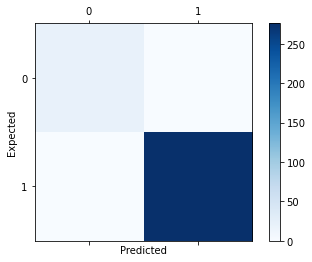

In [428]:
to_drop = ["Speaker Number","binaryClass","Train or Test"]
df_train['Target'] = [0 if x == 'P' else 1 for x in df_train['binaryClass']]
df_train['Sex'] = [0 if x == 'Male' else 1 for x in df_train['Sex']]
df_train.drop(to_drop, axis=1, inplace=True)
# df_train
X = df_train.drop(["Target"], axis=1)
y = df_train["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred)*100)
ConfusionMatrix(y_test,y_pred)

Foi aplicado o knn com os dados normalizados para ver a distribuição geral.

99.66329966329967
Confusion matrix:
 [[ 23   0]
 [  1 273]]


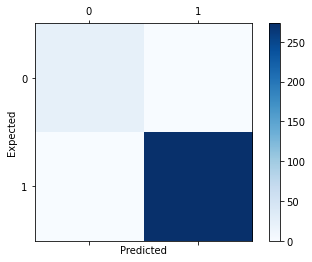

In [429]:
x_dataset_base = df_train.copy()
y_dataset_base = df_train.copy()
x_dataset_base.drop(["Sex","Target"],axis=1, inplace=True)
y_dataset_base = y_dataset_base.Target

columns = df_train.columns
columns.drop(["Sex","Target"])
df_norm = normalize(df_train,columns)
yt,yp,modeloInicialKnn = Knn(df_norm,"Target")
ConfusionMatrix(yt,yp)

Cross Validation

In [430]:
from sklearn.model_selection import cross_val_score

cv_result_dataset = cross_val_score(modeloInicialKnn, x_dataset_base, y_dataset_base,cv=20, scoring="accuracy")
print("Acurácia com cross validation:", cv_result_dataset.mean()*100)

Acurácia com cross validation: 99.18979591836734


Foi observado que os dados estão extremamente desbalanceados, causando uma acurácia de 99% a 100% dependendo da forma em que foi dividido os conjuntos dee teste e treino, portanto farei alguns testes com undersampling e oversampling para tentar balanceá-los.

Class 0: 90
Class 1: 900
Proporção: 10.0 : 1


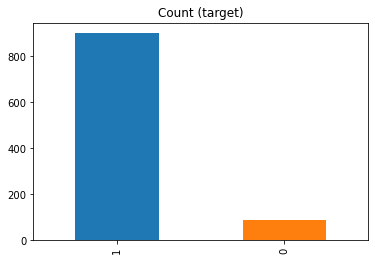

In [431]:
target_count = df_train.Target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proporção:', round(target_count[1] / target_count[0], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

Foi feito um calculo de proporção para saber o tamanho da mesma, e é observado que existe uma desproporção de dados de 10 para 1 entre as duas classes.

Portanto farei alguns testes de oversampling e undersampling para tentar melhorar o conjunto de teste, prezando manter a acurácia de no mínimo 95% e como ela já está em 100%, no maximo 100, será definido um limite também tanto para o oversampling, quanto para o undersampling, sendo eles, over de no máximo 30% e under de no máximo 70%

#### Aplicando UnderSampling

Random under-sampling:
1    720
0     90
Name: Target, dtype: int64


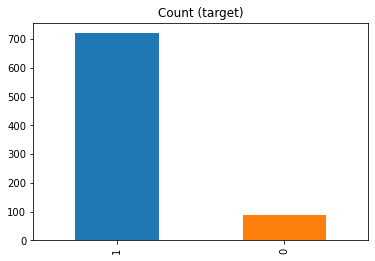

In [432]:
# CONTAR CLASSES
count_class_1, count_class_0 = df_train.Target.value_counts()
# # Divide by class
df_class_0 = df_train[df_train['Target'] == 0]
df_class_1 = df_train[df_train['Target'] == 1]
df_class_1_under = df_class_1.sample(int(count_class_1*0.8))
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random under-sampling:')
print(df_test_under.Target.value_counts())
df_test_under.Target.value_counts().plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

Após fazer o undersampling aplicarei o knn novamente com os mesmo parâmetros de antes(k=3 e distância: Euclidiana).

In [433]:
columns = df_test_under.columns
columns.drop(["Sex","Target"])
df_norm = normalize(df_test_under,columns)

X = df_norm.drop(["Target"], axis=1)
y = df_norm["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Confusion matrix:
 [[ 23   1]
 [  2 217]]


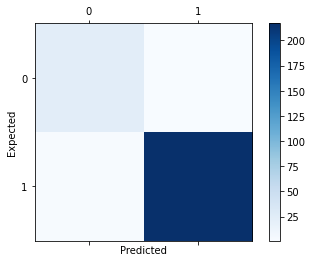

In [434]:
model = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ConfusionMatrix(y_test,y_pred)

Observa-se que a acurácia continua alta
### Oversampling

900 90
Random over-sampling:
1    900
0    105
Name: Target, dtype: int64


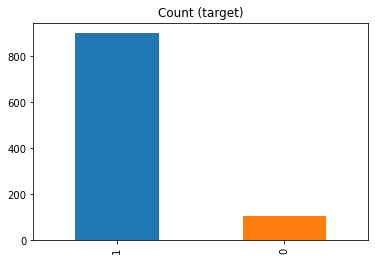

In [435]:
# CONTAR CLASSES
count_class_1, count_class_0 = df_train.Target.value_counts()
print(count_class_1, count_class_0)
# # Divide by class
df_class_0 = df_train[df_train['Target'] == 0]
df_class_1 = df_train[df_train['Target'] == 1]
df_class_0_over = df_class_0.sample(int(count_class_0/0.85),replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.Target.value_counts())
df_test_over.Target.value_counts().plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [436]:
columns = df_test_over.columns
columns.drop(["Sex","Target"])
df_norm = normalize(df_test_over,columns)
X = df_norm.drop(["Target"], axis=1)
y = df_norm["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

99.00662251655629
Confusion matrix:
 [[ 35   3]
 [  0 264]]


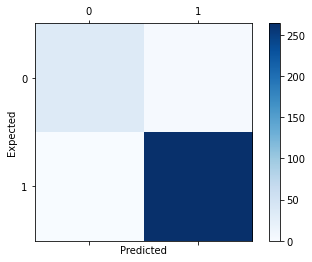

In [437]:
model = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
ConfusionMatrix(y_test,y_pred)

Com oversampling a acurácia bateu 100%.
Tentativa de aplicar tanto o over quanto o under simultaneamente para ver o resultado,

0    630
1    105
Name: Target, dtype: int64


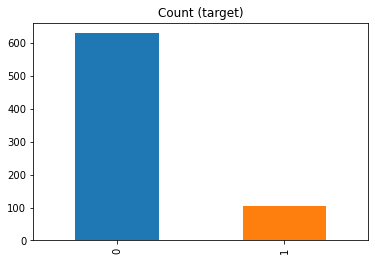

In [438]:
# Contagem das classes
count_class_1, count_class_0 = df_train.Target.value_counts()
# Divisão das classes
df_class_0 = df_train[df_train['Target'] == 0]
df_class_1 = df_train[df_train['Target'] == 1]
df_class_0_over = df_class_0.sample(int(count_class_1*0.7),replace=True)
df_class_1_under = df_class_1.sample(int(count_class_0/0.85))
df_balanced = pd.concat([df_class_0_over, df_class_1_under], axis=0)

print(df_balanced.Target.value_counts())
df_balanced.Target.value_counts().plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [465]:
columns = df_balanced.columns
columns.drop(["Sex","Target"])
df_norm = normalize(df_balanced,columns)
X = df_norm.drop(["Target"], axis=1)
y = df_norm["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


99.09502262443439
Confusion matrix:
 [[186   0]
 [  2  33]]


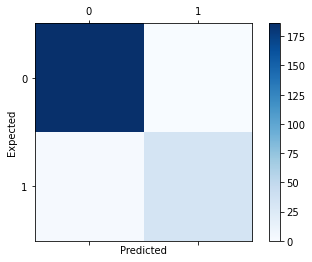

In [466]:
model = KNeighborsClassifier(n_neighbors=3,metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
ConfusionMatrix(y_test,y_pred)

Cheguei nos valores de over = 15% e de under = 70%, onde a acurácia continua alta e os dados estão menos desbalanceados, no entanto o desbalanceamento ainda é alto, o ideal seria ter mais dados para ter um modelo confiável.

Vou gerar vários valores para procurar o melhor k


In [448]:
x = df_balanced.drop('Target', axis = 1)
y = df_balanced['Target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Text(0, 0.5, 'Mean Error')

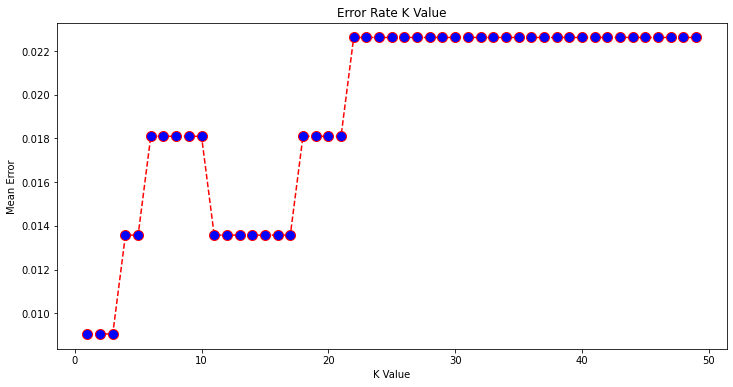

In [450]:
error = []

# Calculating error for K values between 1 and 500
for i in range(1, 50):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 50), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

Com o gráfico consegue-se observar que todos tem um erro minusculo, portanto vou usar k = 5 que não se tem um erro tão grande e tem uma quantidade razoável de vizinhos para comparar.

Aplicando cross validation com o k melhorado para o knn com o dataset balanceado

In [451]:
from sklearn.model_selection import cross_val_score

y = df_balanced['Target']
x = df_balanced.drop(['Target'],axis=1)
classificador = KNeighborsClassifier(n_neighbors=5,metric='euclidean')
cv_result_enhanced = cross_val_score(classificador, x, y, cv=20, scoring="accuracy")
print("Acurácia com cross validation:", cv_result_enhanced.mean()*100)

Acurácia com cross validation: 99.1891891891892


In [452]:
columns = df_balanced.columns
columns.drop(["Sex","Target"])
df_norm = normalize(df_balanced,columns)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

99.5475113122172
Confusion matrix:
 [[193   0]
 [  1  27]]


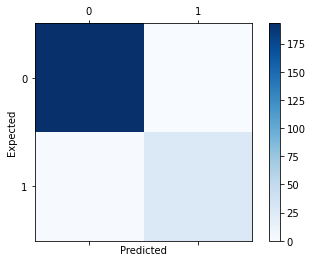

In [453]:
classificador.fit(X_train, y_train)
y_pred = classificador.predict(X_test)
print(accuracy_score(y_test, y_pred)*100)
ConfusionMatrix(y_test,y_pred)

Curva Roc

In [457]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [473]:
y = df_train['Target']
x = df_train.drop(['Target'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

model = KNeighborsClassifier(n_neighbors=11)
model.fit(X_train, y_train)

pred = model.predict(X_test)
probs = model.predict_proba(X_test)

fprOld, tprOld, threshold = metrics.roc_curve(y_test, probs[:,1])
roc_auc_old = metrics.auc(fprOld, tprOld)

In [474]:
y = df_balanced['Target']
x = df_balanced.drop(['Target'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

model = KNeighborsClassifier(n_neighbors=11)
model.fit(X_train, y_train)

pred = model.predict(X_test)
probs = model.predict_proba(X_test)

fprNew, tprNew, threshold = metrics.roc_curve(y_test, probs[:,1])
roc_auc = metrics.auc(fprNew, tprNew)

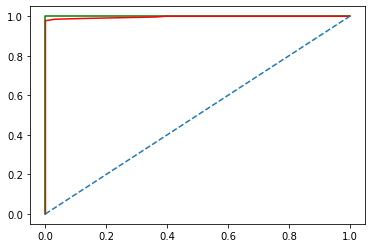

In [475]:
import matplotlib.pyplot as plt

plt.plot(fprNew, tprNew, 'green')
plt.plot(fprOld, tprOld, 'red')
plt.plot([0,1], [0,1], '--')
plt.show()

Como se pode observar houve uma "melhora" na curva hoc.

# Teste de Wilcoxon 

In [454]:
from scipy.stats import wilcoxon

Hipótese H0


H0 = H1

H0 = cv_result_dataset

H1 = cv_result_enhanced



Hipótese H1

H0 != H1


In [456]:
alpha = 0.05
stat, p = wilcoxon( cv_result_enhanced,cv_result_dataset)


if p > alpha:
  print('Hipotese H0 aceita')
else:
  print('Hipotese H0 rejeitada')

Hipotese H0 aceita


Conclusão, mesmo com a tentativa de balancear os dados e melhorar o k no knn o dataset ficou extremamente desbalanceado, mesmo com a acurácia alta, não é possível sem maior quantidade de dados garantir que o algoritmo realmente está funcionando, tendo a hipótese H0 aceita.